In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['figure.figsize'] = (10, 8)

## Heat equation

## $$
\frac{\partial u}{\partial t}=a\frac{\partial^2 u}{\partial x^2}+f(x, t), 0<x<L
$$
### $$
u(x, 0) = u_{t_{0}}, 0\leq x\leq L
$$
### $$
u(0, t) = u_{x_{0}}, t>0
$$
### $$
u(L, t) = u_{x_{L}}, t>0
$$
##### $a-$ thermal diffusivity;
##### $L-$length;
##### $u_{t_{0}}-$initial temperature distribution;
##### $u_{x_{0}}-$left boundary temperature;
##### $u_{x_{L}}-$right boundary temperature;


Let's consider Dirichlet boundary condition, thus $u_{x_{0}}=0, u_{x_{L}}=0$.

Firstly, we are going to take a homogeneous equation, which can be solved analytically, and compare the the results with numerical ones. For an example:

### $
\frac{\partial u}{\partial t}=a\frac{\partial^2 u}{\partial x^2}, 0<x<\pi
$
### $
u(x, 0) = 3sin(2x)-sin(3x), 0\leq x\leq L
$
### $
u(0, t) = 0, t>0
$
### $
u(L, t) = 0, t>0
$

The example was taken form http://kontromat.ru/?page_id=3325. The analytical result is:

### $$
u(x, t) = e^{-4at}sin(2x)-e^{-9at}sin(3x)
$$

In [2]:
def t_dist(x, x_0, x_1):
    """Initialization of temperature distribution"""
    x = np.asarray(x)
    if x.ndim != 1:
        return np.asscalar(x)
    else:
        x[0] = x_0
        x[-1] = x_1
        return x

In [3]:
def init_u(u_t0, x_0, x_1, num):
    """Starting u"""
    u = np.ones((num,))*u_t0
    u[0] = x_0
    u[-1] = x_1
    return u

In [4]:
def f(x, t):
    """Inhomogenuity"""
    return 0

In [5]:
#values
a = 0.001
lng = np.pi #length
n = 500 #number of nodes byx
m = 10000 #number of nodes by t
x = np.linspace(0, lng, n)
u_x0 = 0
u_x1 = 0
u_t0 = t_dist(3*np.sin(2*x)-np.sin(3*x), u_x0, u_x1)
t_end = 3 #total time
h = lng/n #step x
dt = t_end/m #step t
time = 0

In [4]:
def explicit_euler(u_res, a, dt, h, err=3e-4):
    """Explicit Euler difference scheme. Approximation order O(dt, h**2)."""
    if 2*h**2/a - dt < err:
        return None
    for j in range(1, m):
        u = u_res
        for i in range(1, n-1):
            u_res[i] = u[i] + (a*dt/h**2)*(u[i+1] - 2*u[i] + u[i-1]) + dt*f(i*h, j*dt)
    return u_res

In [5]:
def implicit_euler(u_res, a, dt, h):
    """Implicit Euler difference scheme. Using Tridiagonal matrix algorithm. Approximation order O(dt, h**2)."""
    k = 1
    time = 0
    while time < t_end:
        time += dt
        ai = a/(h**2)
        ci = a/(h**2)
        bi = 2*a/(h**2) + 1/dt 
        alfa = np.zeros(n-1)
        beta = np.zeros(n-1)
        beta[0] = u_x0
        for i in range(1, n-1):
            fi = -u_res[i]/dt - f(i*h, k*dt)
            alfa[i] = ai/(bi-ci*alfa[i-1])
            beta[i] = (ci*beta[i-1]-fi)/(bi-ci*alfa[i-1])
        u_res[-1] = u_x1
        for i in range(n-2, 0, -1):
            u_res[i] = alfa[i]*u_res[i+1]+beta[i]
        k += 1
    return u_res

In [6]:
def crank_nicolson(u_res, a, dt, h):
    """Crank-Nicolson difference scheme. Using Tridiagonal matrix algorithm. Approximation order O(dt**2, h**2)."""
    k = 1
    time = 0
    while time < t_end:
        time += dt
        ai = a/(2*h**2)
        ci = a/(2*h**2)
        bi = a/(h**2) + 1/dt 
        alfa = np.zeros(n-1)
        beta = np.zeros(n-1)
        beta[0] = u_x0
        for i in range(1, n-1):
            fi = -u_res[i]/dt - a/(2*h**2)*(u_res[i+1] - 2*u_res[i] + u_res[i-1]) - f(i*h, k*dt)
            alfa[i] = ai/(bi-ci*alfa[i-1])
            beta[i] = (ci*beta[i-1]-fi)/(bi-ci*alfa[i-1])
        u_res[-1] = u_x1
        for i in range(n-2, 0, -1):
            u_res[i] = alfa[i]*u_res[i+1]+beta[i]
        k+=1
    return u_res

In [7]:
def sauliev(u_res, a, dt, h):
    """Sauliev difference scheme. Approximation order O(dt**2, h**2)."""
    u_res = u
    for j in range(1, m, 2):
        for i in range(1, n-1):
            u[i] =(u_res[i] + (a*dt/h**2)*(u_res[i+1] - u_res[i] + u[i-1]) + dt*f(i*h, j*dt))/(1 + a*dt/h**2)

        for i in range(n-2, 1, -1):
            u_res[i] = (u[i] + (a*dt/h**2)*(u_res[i+1] - u[i] + u[i-1]) + dt*f(i*h, j*dt))/(1 + a*dt/h**2)
    return u_res

In [17]:
u = init_u(u_t0, u_x0, u_x1, n)
u_ee = explicit_euler(u, a, dt, h)
u = init_u(u_t0, u_x0, u_x1, n)
u_ie = implicit_euler(u, a, dt, h)
u = init_u(u_t0, u_x0, u_x1, n)
u_cn = crank_nicolson(u, a, dt, h)
u = init_u(u_t0, u_x0, u_x1, n)
u_s = sauliev(u, a, dt, h)

<IPython.core.display.Javascript object>


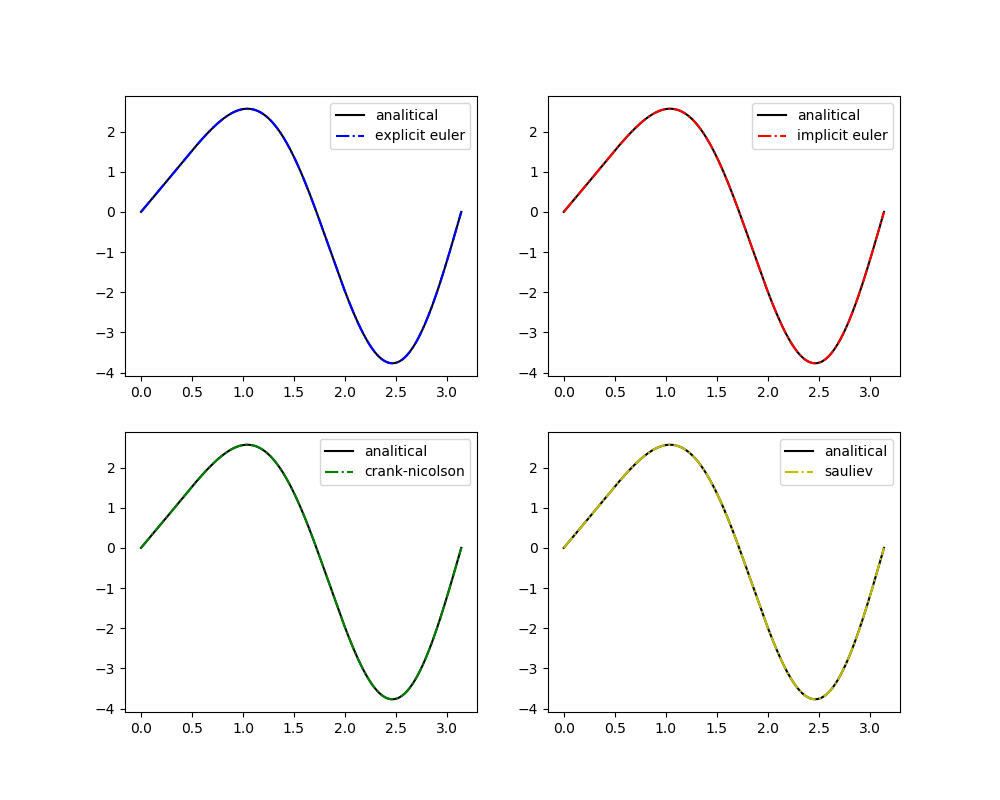

In [28]:
fig, ax= plt.subplots(nrows=2, ncols=2)
ax[0][0].plot(np.linspace(0, lng, n), 3*np.exp(-4*a*t_end)*np.sin(2*x)-np.exp(-9*a*t_end)*np.sin(3*x), 'k', label="analitical")
ax[0][0].plot(np.linspace(0, lng, n), u_ee, '-.b', label="explicit euler")

ax[0][1].plot(np.linspace(0, lng, n), 3*np.exp(-4*a*t_end)*np.sin(2*x)-np.exp(-9*a*t_end)*np.sin(3*x), 'k', label="analitical") 
ax[0][1].plot(np.linspace(0, lng, n), u_ie, '-.r', label="implicit euler")

ax[1][0].plot(np.linspace(0, lng, n), 3*np.exp(-4*a*t_end)*np.sin(2*x)-np.exp(-9*a*t_end)*np.sin(3*x), 'k', label="analitical") 
ax[1][0].plot(np.linspace(0, lng, n), u_cn, '-.g', label="crank-nicolson")

ax[1][1].plot(np.linspace(0, lng, n), 3*np.exp(-4*a*t_end)*np.sin(2*x)-np.exp(-9*a*t_end)*np.sin(3*x), 'k', label="analitical") 
ax[1][1].plot(np.linspace(0, lng, n), u_s, '-.y', label="sauliev")

ax[0][0].legend(loc='best')
ax[0][1].legend(loc='best')
ax[1][0].legend(loc='best')
ax[1][1].legend(loc='best')

## Extra

http://www.math.ualberta.ca/~xinweiyu/201.ev1.12w/201.ev1.12.Lec34.pdf

In [9]:
def f(x, t):
    """Inhomogenuity"""
    return 5

In [8]:
#values
a = 3
lng = np.pi #length
n = 1000 #number of nodes byx
m = 20000 #number of nodes by t
x = np.linspace(0, lng, n)
u_x0 = 1
u_x1 = 1
u_t0 = t_dist(1, u_x0, u_x1)
t_end = 2 #total time
h = lng/n #step x
dt = t_end/m #step t
time = 0

In [11]:
# u = init_u(u_t0, u_x0, u_x1, n)
# u_ee = explicit_euler(u, a, dt, h)
u = init_u(u_t0, u_x0, u_x1, n)
u_ie = implicit_euler(u, a, dt, h)
u = init_u(u_t0, u_x0, u_x1, n)
u_cn = crank_nicolson(u, a, dt, h)
u = init_u(u_t0, u_x0, u_x1, n)
u_s = sauliev(u, a, dt, h)

In [12]:
k=10000
res = np.zeros((n,))
for i in range(k):
    res += ((5/(3*k))*np.exp(-12*k**2*t_end)*np.sin(2*k*x))
res += (5*x/6)*(np.pi-x)+1

<IPython.core.display.Javascript object>


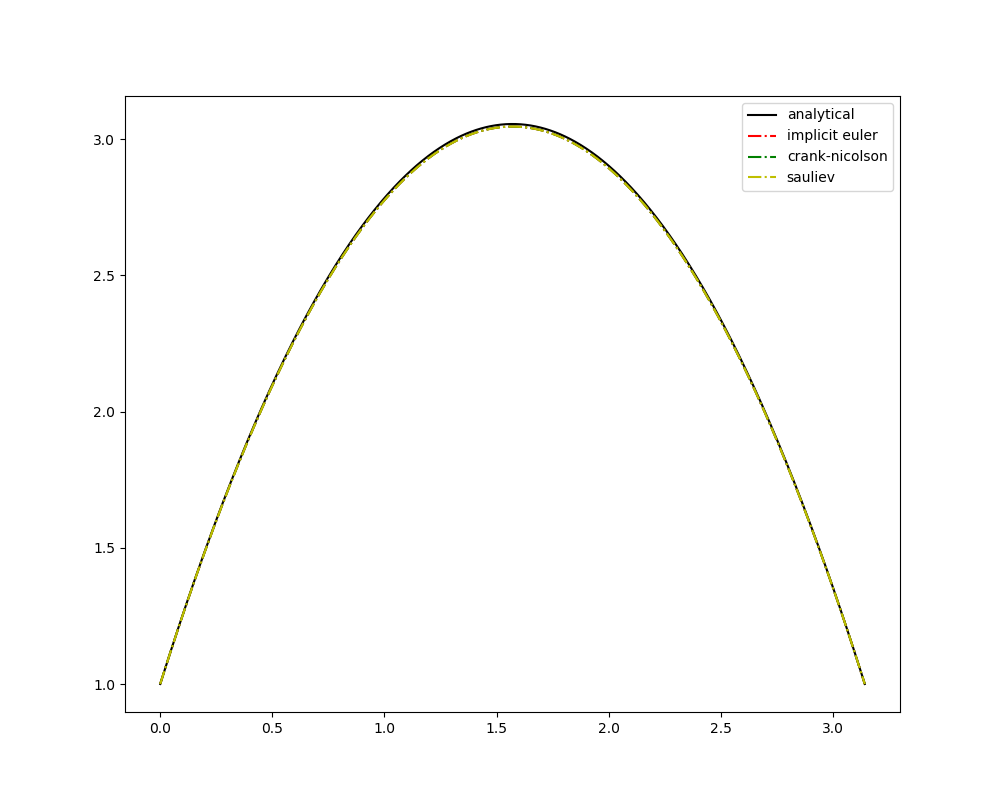

In [13]:
plt.plot(np.linspace(0, lng, n), res, 'k', label="analytical")
# plt.plot(np.linspace(0, lng, n), u_ee, '-.b', label="explicit euler")
plt.plot(np.linspace(0, lng, n), u_ie, '-.r', label="implicit euler")
plt.plot(np.linspace(0, lng, n), u_cn, '-.g', label="crank-nicolson")
plt.plot(np.linspace(0, lng, n), u_s, '-.y', label="sauliev")

plt.legend(loc='best')

In [36]:
def f(x, t):
    """Inhomogenuity"""
    return x

In [37]:
#values
a = 3
lng = np.pi #length
n = 500 #number of nodes byx
m = 10000 #number of nodes by t
x = np.linspace(0, lng, n)
u_x0 = 0
u_x1 = 0
u_t0 = t_dist(np.sin(x), u_x0, u_x1)
t_end = 2 #total time
h = lng/n #step x
dt = t_end/m #step t
time = 0

In [38]:
# u = init_u(u_t0, u_x0, u_x1, n)
# u_ee = explicit_euler(u, a, dt, h)
# u = init_u(u_t0, u_x0, u_x1, n)
# u_ie = implicit_euler(u, a, dt, h)
u = init_u(u_t0, u_x0, u_x1, n)
u_cn = crank_nicolson(u, a, dt, h)
# u = init_u(u_t0, u_x0, u_x1, n)
# u_s = sauliev(u, a, dt, h)

In [39]:
k=100000
res = np.zeros((n,))
for i in range(k):
    res += (2/3)*((1/(4*k**3))*np.exp(-12*k**2*t_end)*np.sin(2*k*x) - (2/(2*k-1)**3)*np.exp(-3*(2*k-1)**2*t_end)*np.sin((2*k-1)*x))
res += np.exp(-3*t_end)*np.sin(x) + (x/6)*(x**2-np.pi**2)

<IPython.core.display.Javascript object>


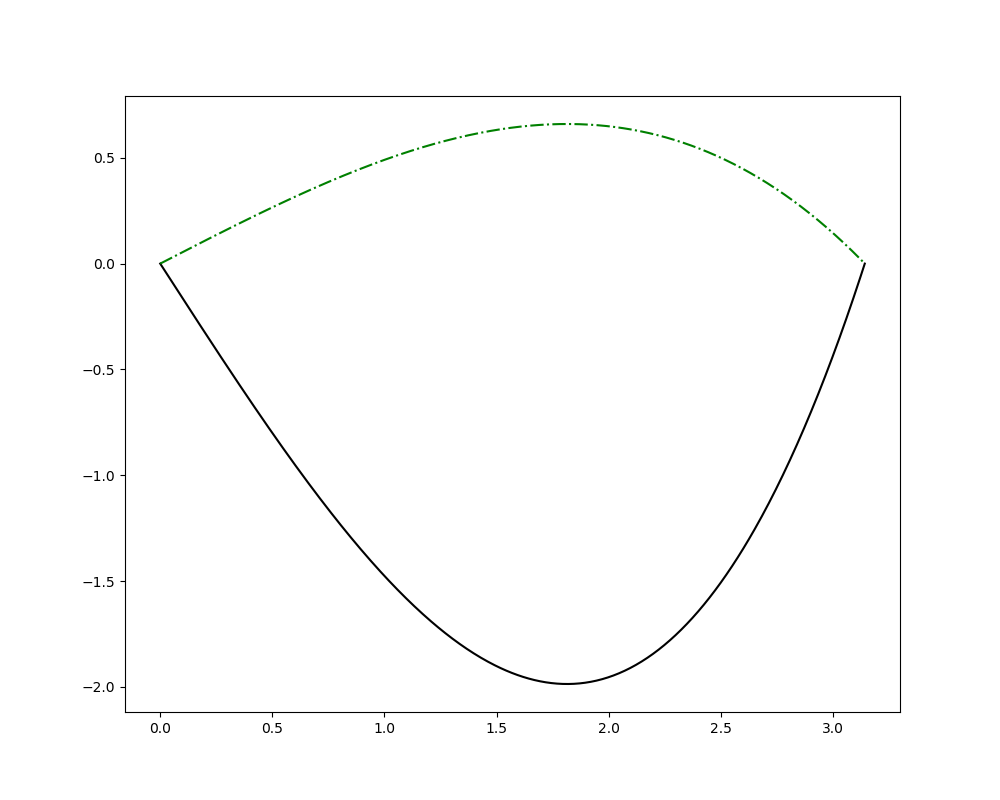

In [40]:
plt.plot(np.linspace(0, lng, n), res, 'k', label="analytical")
# plt.plot(np.linspace(0, lng, n), u_ee, '-.b', label="explicit euler")
# plt.plot(np.linspace(0, lng, n), u_ie, '-.r', label="implicit euler")
plt.plot(np.linspace(0, lng, n), u_cn, '-.g', label="crank-nicolson")
# plt.plot(np.linspace(0, lng, n), u_s, '-.y', label="sauliev")

https://www.matburo.ru/Examples/Files/umf_3.pdf

In [14]:
def f(x, t):
    """Inhomogenuity"""
    return 2*x+1

In [15]:
#values
a = 1
lng = 1 #length
n = 1000 #number of nodes byx
m = 20000 #number of nodes by t
x = np.linspace(0, lng, n)
u_x0 = 1
u_x1 = 2
u_t0 = t_dist(x+1, u_x0, u_x1)
t_end = 2 #total time
h = lng/n #step x
dt = t_end/m #step t
time = 0

In [16]:
# u = init_u(u_t0, u_x0, u_x1, n)
# u_ee = explicit_euler(u, a, dt, h)
u = init_u(u_t0, u_x0, u_x1, n)
u_ie = implicit_euler(u, a, dt, h)
u = init_u(u_t0, u_x0, u_x1, n)
u_cn = crank_nicolson(u, a, dt, h)
u = init_u(u_t0, u_x0, u_x1, n)
u_s = sauliev(u, a, dt, h)

In [17]:
k=1000000
res = np.zeros((n,))
for i in range(k):
    res += ((6*(-1)**(k+1)+2)/((np.pi*k)**3 * a**2))*np.sin(k*np.pi*x/lng)*(1-np.exp(-t_end*(a*np.pi*k/lng)**2))
res += x+1

<IPython.core.display.Javascript object>


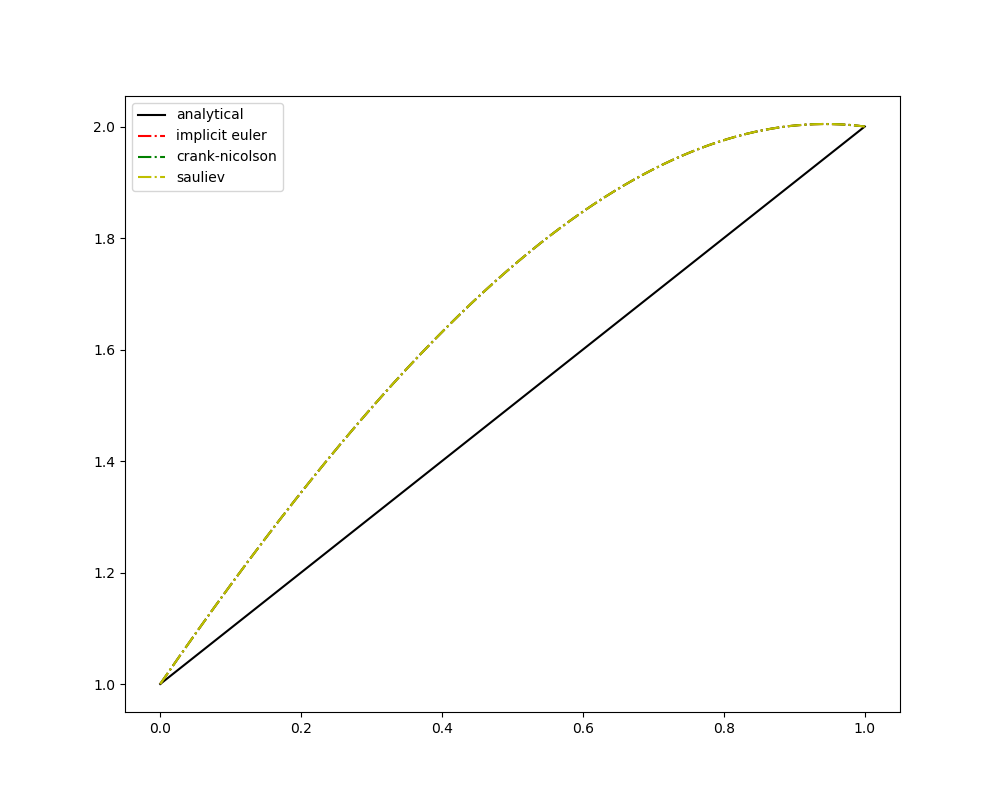

In [18]:
plt.plot(np.linspace(0, lng, n), res, 'k', label="analytical")
# plt.plot(np.linspace(0, lng, n), u_ee, '-.b', label="explicit euler")
plt.plot(np.linspace(0, lng, n), u_ie, '-.r', label="implicit euler")
plt.plot(np.linspace(0, lng, n), u_cn, '-.g', label="crank-nicolson")
plt.plot(np.linspace(0, lng, n), u_s, '-.y', label="sauliev")

plt.legend(loc='best')